# Ten Stock Optimal Portfolio using Quadratic Programming

First ten stock by alphabatically order. Period from 1 Jan 2014 to 31 Dec 2018.

Daily adj. closing price. Annualized returns assume 252 trading days.


Candidate portfolio generated by random weights.


References:
    1. Ricky Kim https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
    2. Bernard Brenyah Blog post Markowitz’s Efficient Frontier in Python [Part 1/2]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import pandas_datareader as pdr
import datetime as dt

In [2]:
stocks = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH', 'BJC', 'BTS']
start = dt.datetime(2018,1,1)
end = dt.datetime(2018,12,31) # end is optional

df = pd.DataFrame()
dataset = {}
for s in stocks:
    try:
        data = pdr.get_data_yahoo('%s.BK' % s,start=start,end=end)
        data['ticker'] = s # add ticker to column
        data['adj_close'] = data['Adj Close']
        dataset[s] = data[['ticker', 'adj_close']] # Need two columns
        df = pd.concat([df, dataset[s]])
    except Exception as e:
        print("Error: %s %s" % (s, str(e)))


table = df.pivot(columns='ticker')
table

adj_close                                                         \
ticker          ADVANC        AOT      BANPU         BBL       BDMS       BEM   
Date                                                                            
2018-01-03  179.664856  68.374878  16.489782  183.849182  20.034538  7.447678   
2018-01-04  177.379044  68.374878  17.419977  183.849182  20.129940  7.399628   
2018-01-05  178.293350  69.829666  17.589100  184.746002  19.939137  7.591827   
2018-01-08  179.207687  72.011841  17.335413  185.642838  20.034538  7.495728   
2018-01-09  177.836212  71.041992  18.181044  186.539658  20.034538  7.543777   
...                ...        ...        ...         ...        ...       ...   
2018-12-24  163.651642  64.083893  14.114557  190.823547  25.665375  9.962773   
2018-12-25  162.228592  61.865604  13.588550  188.044571  25.181122  9.718588   
2018-12-26  161.754242  63.097988  13.500880  187.118240  25.423250  9.279055   
2018-12-27  160.805542  62.358559  13.500880  184.339264  23.728367  9.425565   
2018-12-28  163.651642  63.344463  12.974873  188.044571  24.018917  9.474402   

                                                        
ticker          BGRIM          BH        BJC       BTS  
Date                                                    
2018-01-03  29.263739  179.891403  62.579559  7.480615  
2018-01-04  29.505589  181.765289  61.620480  7.480615  
2018-01-05  29.989288  180.359879  61.380718  7.435550  
2018-01-08  29.505589  178.017548  58.503494  7.480615  
2018-01-09  29.505589  179.891403  57.064888  7.615807  
...               ...         ...        ...       ...  
2018-12-24  26.334829  185.820419  51.096230  9.048749  
2018-12-25  25.842588  181.543243  48.916767  8.861211  
2018-12-26  25.842588  182.018463  49.401096  8.861211  
2018-12-27  25.596470  175.365051  48.432446  8.814325  
2018-12-28  26.088709  178.216507  49.158932  8.954980  

[245 rows x 10 columns]

In [3]:
plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# df = data.set_index('date')
# table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column table.columns = [col[1] for col in table.columns] 
table.head()

adj_close                                                         \
ticker          ADVANC        AOT      BANPU         BBL       BDMS       BEM   
Date                                                                            
2018-01-03  179.664856  68.374878  16.489782  183.849182  20.034538  7.447678   
2018-01-04  177.379044  68.374878  17.419977  183.849182  20.129940  7.399628   
2018-01-05  178.293350  69.829666  17.589100  184.746002  19.939137  7.591827   
2018-01-08  179.207687  72.011841  17.335413  185.642838  20.034538  7.495728   
2018-01-09  177.836212  71.041992  18.181044  186.539658  20.034538  7.543777   

                                                        
ticker          BGRIM          BH        BJC       BTS  
Date                                                    
2018-01-03  29.263739  179.891403  62.579559  7.480615  
2018-01-04  29.505589  181.765289  61.620480  7.480615  
2018-01-05  29.989288  180.359879  61.380718  7.435550  
2018-01-08  29.505589  178.017548  58.503494  7.480615  
2018-01-09  29.505589  179.891403  57.064888  7.615807

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price in $')

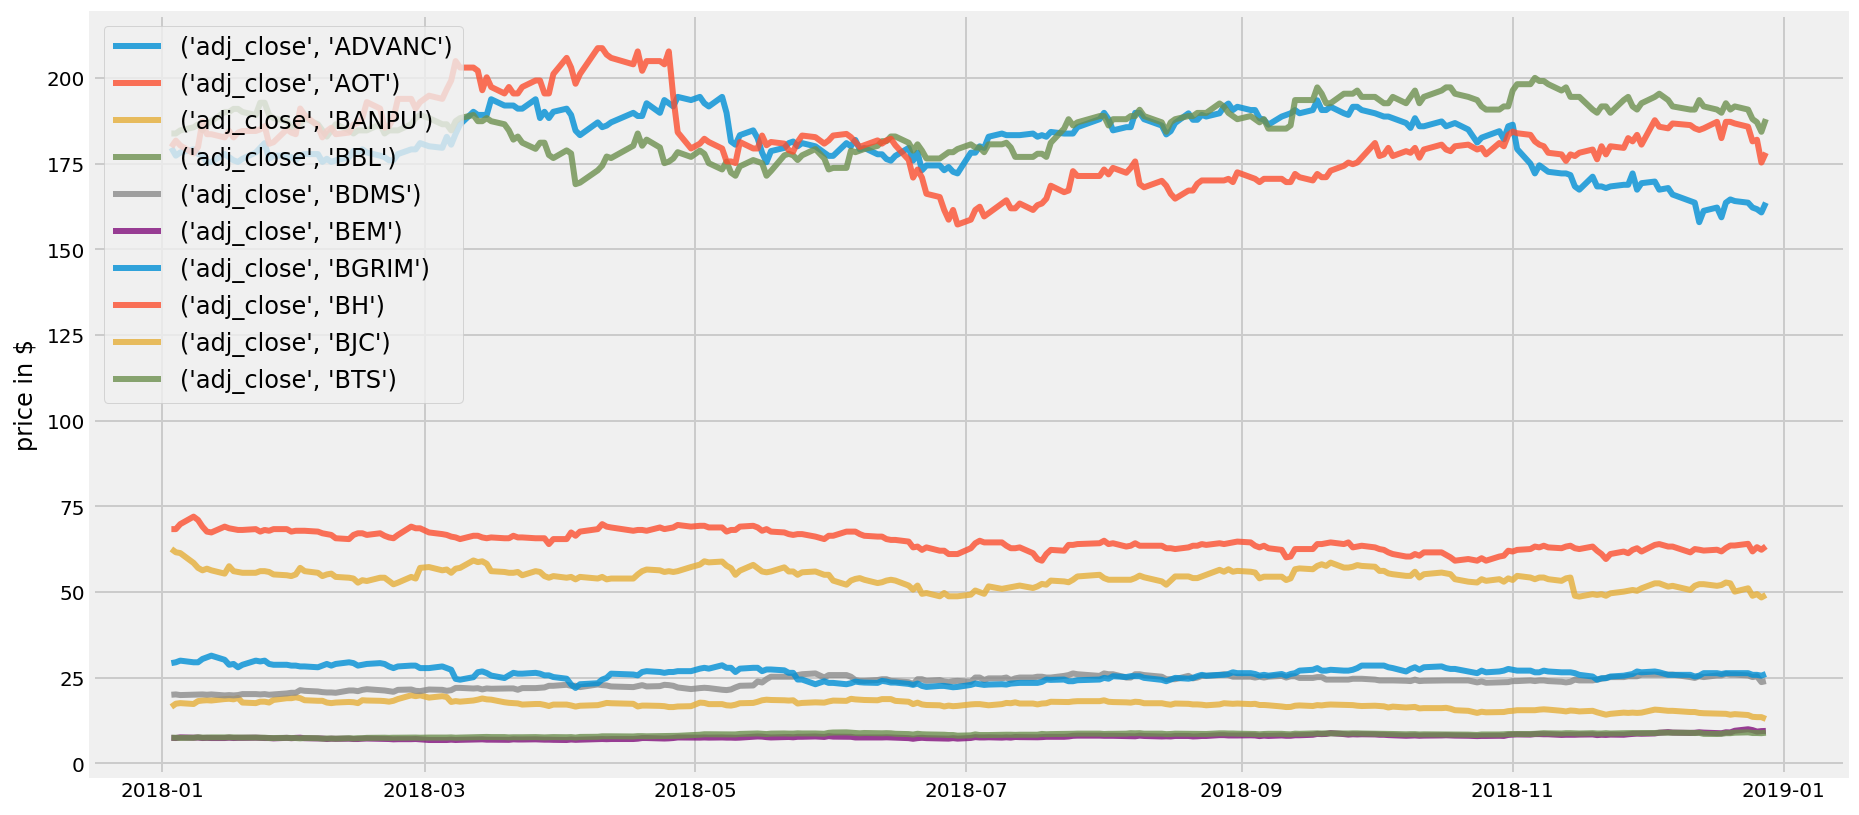

In [5]:
# Plot table
# look at how the price of each stock has evolved within the given time frame.

plt.figure(figsize=(14, 7)) 
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c) 
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

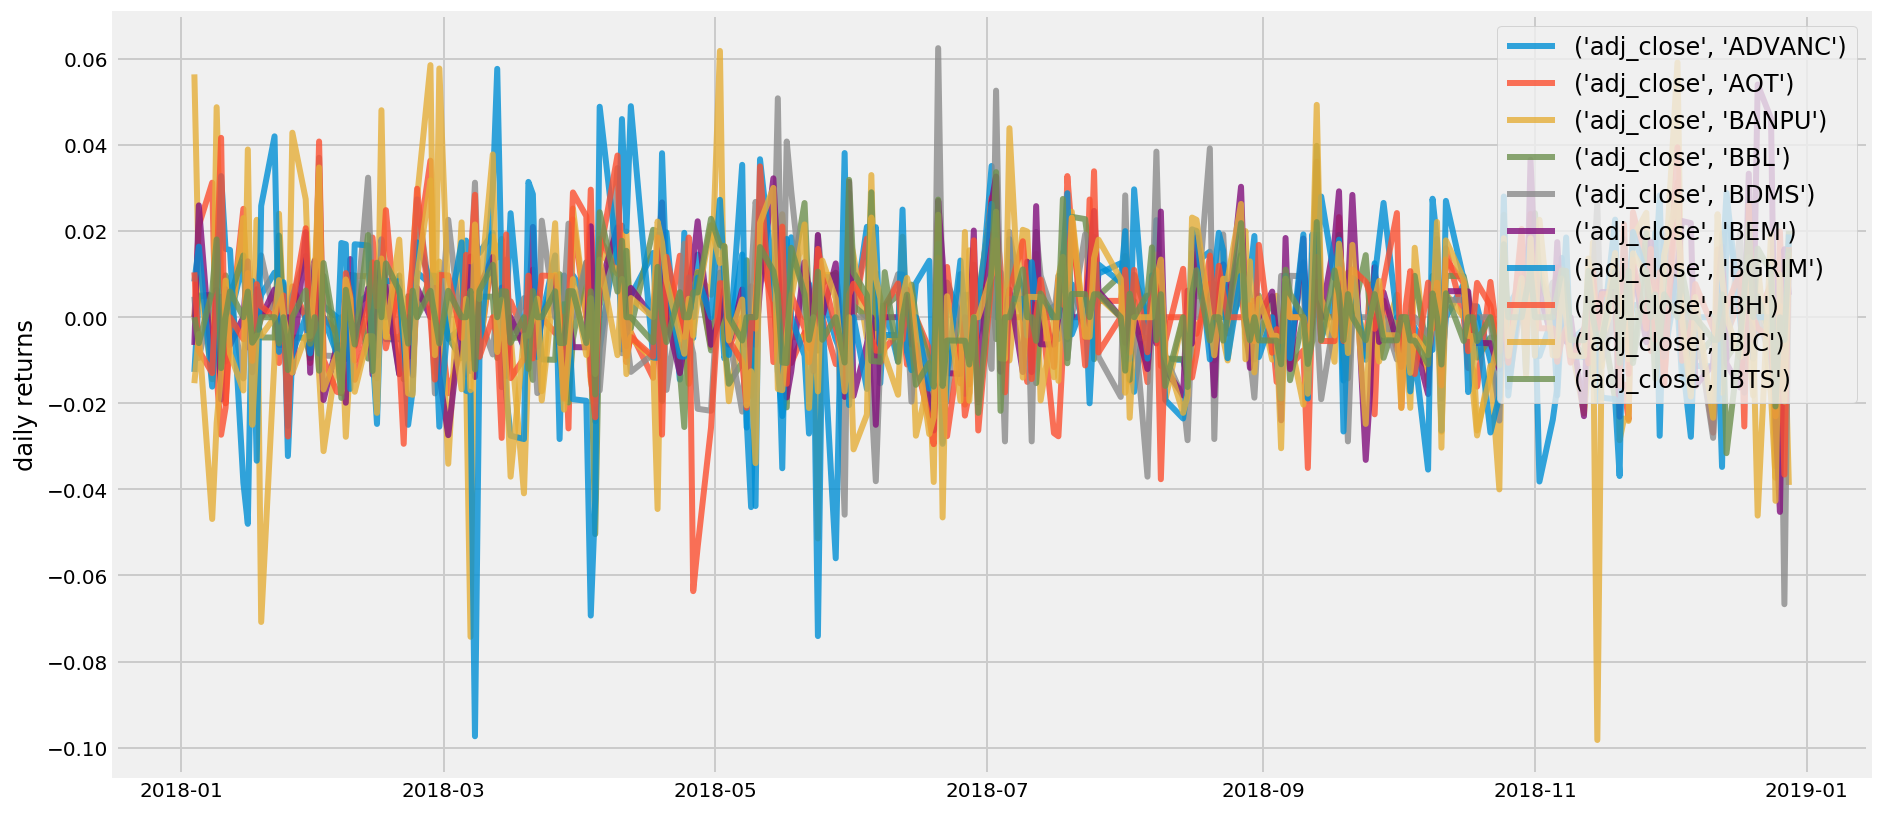

In [6]:
# some stock price is relatively more expensive than others.
# Do daily return
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c) 
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [7]:
# Random Portfolios Generation
# We have 10 stocks in our portfolio.

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in xrange(num_portfolios):
        weights = np.random.random(10) # 10 stocks
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [8]:
returns = table.pct_change()
returns

adj_close                                                    \
ticker        ADVANC       AOT     BANPU       BBL      BDMS       BEM   
Date                                                                     
2018-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-04 -0.012723  0.000000  0.056410  0.000000  0.004762 -0.006452   
2018-01-05  0.005155  0.021277  0.009709  0.004878 -0.009479  0.025974   
2018-01-08  0.005128  0.031250 -0.014423  0.004854  0.004785 -0.012658   
2018-01-09 -0.007653 -0.013468  0.048781  0.004831  0.000000  0.006410   
...              ...       ...       ...       ...       ...       ...   
2018-12-24 -0.002890  0.007752 -0.018293 -0.004831 -0.009346  0.046154   
2018-12-25 -0.008696 -0.034615 -0.037267 -0.014563 -0.018868 -0.024510   
2018-12-26 -0.002924  0.019920 -0.006452 -0.004926  0.009615 -0.045226   
2018-12-27 -0.005865 -0.011719  0.000000 -0.014851 -0.066667  0.015789   
2018-12-28  0.017699  0.015810 -0.038961  0.020100  0.012245  0.005181   

                                                    
ticker         BGRIM        BH       BJC       BTS  
Date                                                
2018-01-03       NaN       NaN       NaN       NaN  
2018-01-04  0.008264  0.010417 -0.015326  0.000000  
2018-01-05  0.016393 -0.007732 -0.003891 -0.006024  
2018-01-08 -0.016129 -0.012987 -0.046875  0.006061  
2018-01-09  0.000000  0.010526 -0.024590  0.018072  
...              ...       ...       ...       ...  
2018-12-24  0.000000 -0.005089  0.019324  0.010471  
2018-12-25 -0.018692 -0.023018 -0.042654 -0.020725  
2018-12-26  0.000000  0.002618  0.009901  0.000000  
2018-12-27 -0.009524 -0.036553 -0.019608 -0.005291  
2018-12-28  0.019231  0.016260  0.015000  0.015957  

[245 rows x 10 columns]

In [9]:
returns = returns.dropna()
returns = table.pct_change() 
mean_returns = returns.mean()

cov_matrix = returns.cov() 
num_portfolios = 25000 
risk_free_rate = 0.0178

In [10]:
# Generate random portfolio.

# Locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign.
# for minimum volatility portfolio, and displays it as a green star 

# And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.
xrange = range # Python3 compat

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.12


           adj_close                                                         
ticker        ADVANC  AOT BANPU   BBL   BDMS    BEM BGRIM     BH   BJC    BTS
allocation     12.99  1.5  0.32  6.95  13.83  19.65  4.92  10.77  1.82  27.26
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.06
Annualised Volatility: 0.11


           adj_close                                                          
ticker        ADVANC   AOT BANPU    BBL  BDMS    BEM BGRIM     BH   BJC    BTS
allocation     18.94  6.47  2.51  18.06  4.69  11.02  5.49  12.28  0.58  19.95


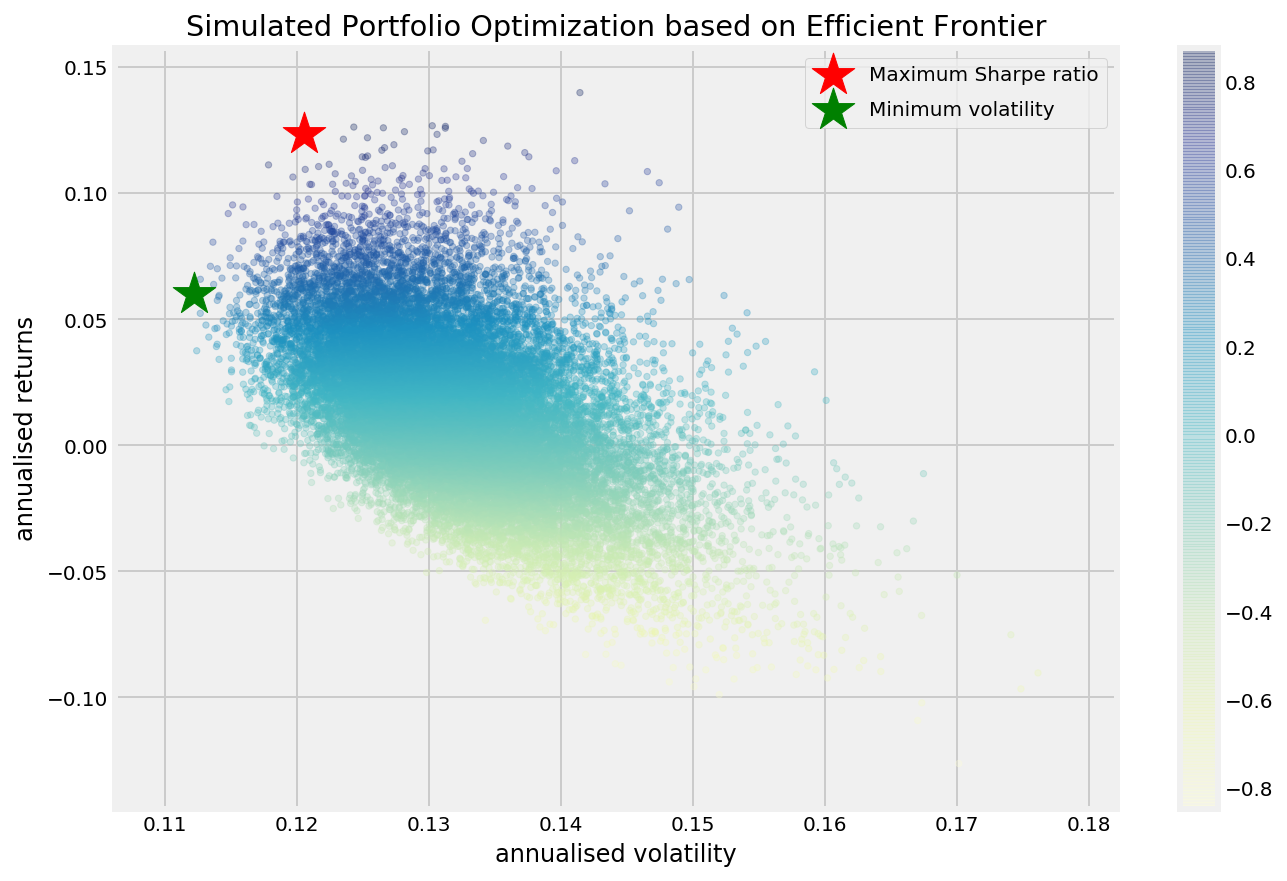

In [11]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Solve for efficient frontier 


To maximize Sharpe ratio the objective function is set to minimize negative Sharpe ratio neg_sharpe_ratio().

To minize variance, objective function is set to minimize variance portfolio_volatility().

Explicit constraint:

Sum equals 1
```bash
constraints = ({‘type’: ‘eq’, ‘fun’: lambda x: np.sum(x) — 1})
```

In [12]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [13]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [14]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [15]:
# ef_06.py  https://gist.github.com/tthustla/c4c6be0261c9caf1e052f7b6f29e844e

def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.15


           adj_close                                                    
ticker        ADVANC  AOT BANPU  BBL   BDMS   BEM BGRIM   BH  BJC    BTS
allocation       0.0  0.0   0.0  0.0  18.59  32.3   0.0  0.0  0.0  49.11
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.11


           adj_close                                                       
ticker        ADVANC   AOT BANPU    BBL  BDMS   BEM BGRIM    BH  BJC    BTS
allocation     18.32  9.65   0.0  24.17  6.44  3.32  3.11  5.82  0.0  29.18


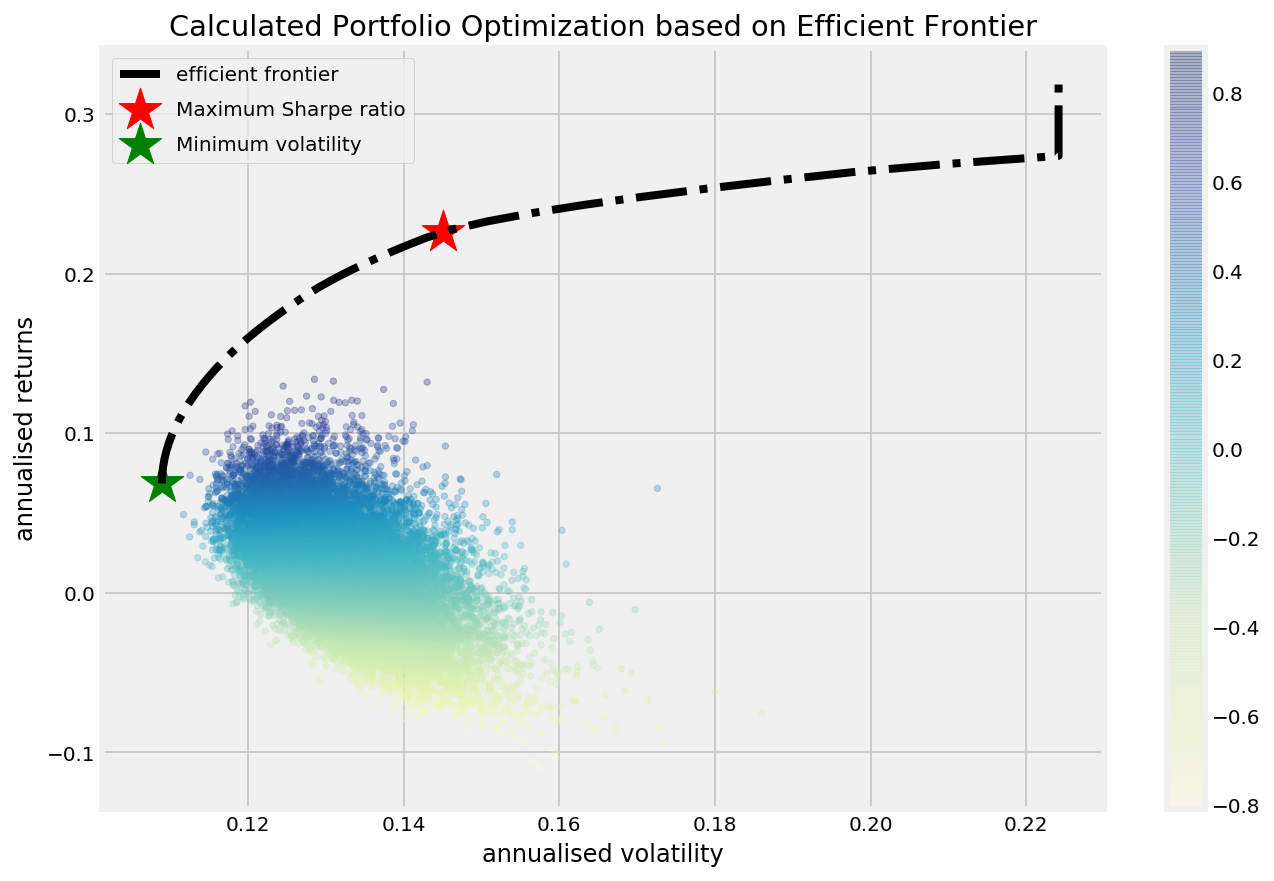

In [16]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [19]:
# ef_07.py https://gist.githubusercontent.com/tthustla/bcea033104fd18b933b01813d193dab2/raw/53003564b34585953328df382bbe55c582661d51/ef_07.py

global res
res = {}


def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    res[0] = max_sharpe_allocation
    res[1] = min_vol_allocation
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.23
Annualised Volatility: 0.15


           adj_close                                                    
ticker        ADVANC  AOT BANPU  BBL   BDMS   BEM BGRIM   BH  BJC    BTS
allocation       0.0  0.0   0.0  0.0  18.59  32.3   0.0  0.0  0.0  49.11
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.11


           adj_close                                                       
ticker        ADVANC   AOT BANPU    BBL  BDMS   BEM BGRIM    BH  BJC    BTS
allocation     18.32  9.65   0.0  24.17  6.44  3.32  3.11  5.82  0.0  29.18
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

('adj_close', 'ADVANC') : annuaised return -0.08 , annualised volatility: 0.1

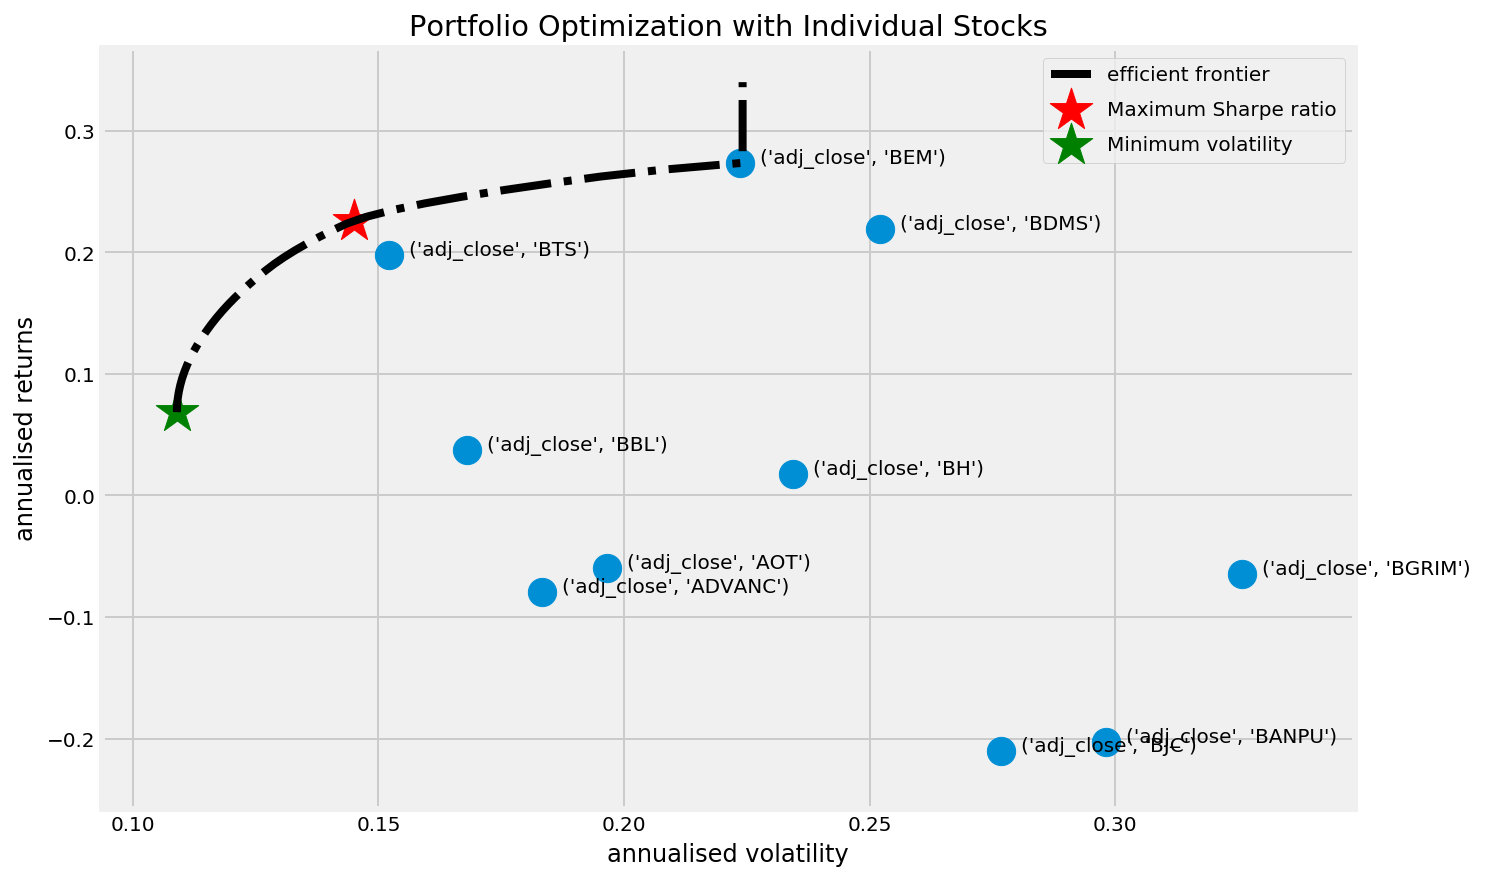

In [21]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [22]:
res

{0:            adj_close                                                    
 ticker        ADVANC  AOT BANPU  BBL   BDMS   BEM BGRIM   BH  BJC    BTS
 allocation       0.0  0.0   0.0  0.0  18.59  32.3   0.0  0.0  0.0  49.11,
 1:            adj_close                                                       
 ticker        ADVANC   AOT BANPU    BBL  BDMS   BEM BGRIM    BH  BJC    BTS
 allocation     18.32  9.65   0.0  24.17  6.44  3.32  3.11  5.82  0.0  29.18}

In [25]:
# Min Vol
import pandas as pd
dat = res[1]
dat = res[1]
dat

adj_close                                                       
ticker        ADVANC   AOT BANPU    BBL  BDMS   BEM BGRIM    BH  BJC    BTS
allocation     18.32  9.65   0.0  24.17  6.44  3.32  3.11  5.82  0.0  29.18

In [24]:
# Max Sharpe
import pandas as pd
dat = res[0]
dat = res[0]
dat

adj_close                                                       
ticker        ADVANC   AOT BANPU    BBL  BDMS   BEM BGRIM    BH  BJC    BTS
allocation     18.32  9.65   0.0  24.17  6.44  3.32  3.11  5.82  0.0  29.18